# Import Libraries

In [4]:
import os
import cv2
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras import layers, optimizers
from keras.optimizers import RMSprop
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
%cd /content/drive/MyDrive/Computer Vision Portfolio/Chest X-Ray Disease Classification Model/

/content/drive/MyDrive/Computer Vision Portfolio/Chest X-Ray Disease Classification Model


# Load Data

In [18]:
XRay_Directory = '/content/drive/My Drive/Computer Vision Portfolio/Chest X-Ray Disease Classification Model/Dataset'

In [19]:
os.listdir(XRay_Directory)

['1', '0', '2', '3']

In [8]:
# create image generator & rescale images
# use 20% of data for cross-validation
image_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

In [ ]:
# shuffling and image resizing
train_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="training")

Found 428 images belonging to 4 classes.


In [ ]:
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="validation")

Found 104 images belonging to 4 classes.


In [ ]:
# generate batch of 40 images and labels
train_images, train_labels = next(train_generator)

In [ ]:
train_images.shape

(40, 256, 256, 3)

In [ ]:
train_labels.shape

(40, 4)

In [ ]:
# label mapping
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

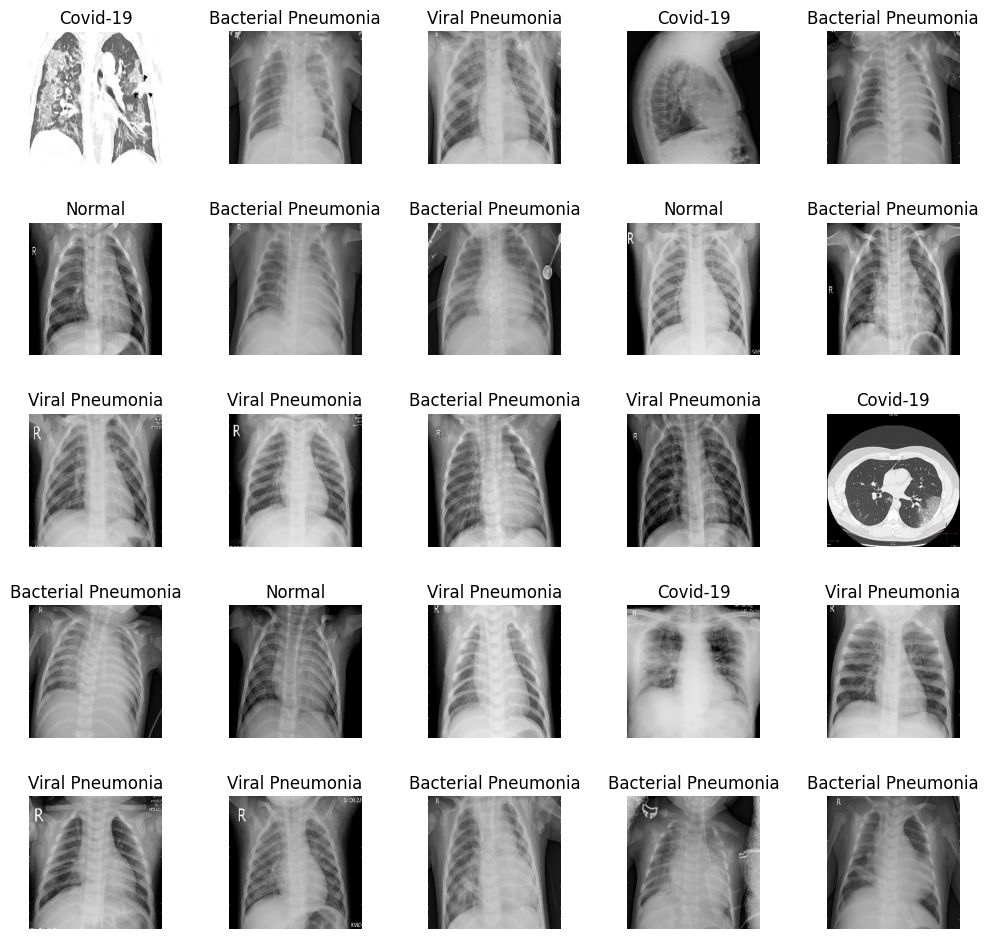

In [ ]:
# visualize images
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)


# Transfer Learning

In [ ]:
basemodel = ResNet50(include_top = False, weights= 'imagenet', input_shape = (256, 256, 3))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
#  freeze the last 10 layers
for layer in basemodel.layers[:-10]:
  layer.trainable = False

# Build Model

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten()(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

In [ ]:
model = Model(inputs = basemodel.inputs , outputs = headmodel)

In [ ]:
# adam = Adam(learning_rate=0.00001)
model.compile(optimizer = RMSprop(learning_rate = 1e-4), loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [ ]:
earlystopping = EarlyStopping(monitor = 'val_loss', verbose = 1, patience = 20, mode = 'min')

checkpointer = ModelCheckpoint(filepath = 'model_weights.hdf5', save_best_only = True, verbose = 1 )

In [ ]:
train_generator = image_generator.flow_from_directory(class_mode = 'categorical', batch_size = 4, shuffle = True, directory = XRay_Directory, target_size = (256,256), subset = 'training' )
val_generator = image_generator.flow_from_directory(class_mode = 'categorical', batch_size = 4, shuffle = True, directory = XRay_Directory, target_size = (256,256), subset = 'validation' )

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [ ]:
# history = model.fit_generator(train_generator,steps_per_epoch= train_generator.n // 4, epochs = 25, validation_data = val_generator, callbacks = [earlystopping, checkpointer])

<ipython-input-22-3c15dad50a3b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,steps_per_epoch= train_generator.n // 4, epochs = 25, validation_data = val_generator, callbacks = [earlystopping, checkpointer])


Epoch 1/25
107/107 [==============================] - ETA: 0s - loss: 1.4748 - accuracy: 0.2921
Epoch 1: val_loss improved from inf to 1.35764, saving model to model_weights.hdf5
107/107 [==============================] - 202s 2s/step - loss: 1.4748 - accuracy: 0.2921 - val_loss: 1.3576 - val_accuracy: 0.2981
Epoch 2/25
107/107 [==============================] - ETA: 0s - loss: 1.1068 - accuracy: 0.5070
Epoch 2: val_loss improved from 1.35764 to 1.13609, saving model to model_weights.hdf5
107/107 [==============================] - 178s 2s/step - loss: 1.1068 - accuracy: 0.5070 - val_loss: 1.1361 - val_accuracy: 0.5192
Epoch 3/25
107/107 [==============================] - ETA: 0s - loss: 0.9743 - accuracy: 0.6215
Epoch 3: val_loss improved from 1.13609 to 0.99208, saving model to model_weights.hdf5
107/107 [==============================] - 177s 2s/step - loss: 0.9743 - accuracy: 0.6215 - val_loss: 0.9921 - val_accuracy: 0.5962
Epoch 4/25
107/107 [==============================] - ETA: 

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)

# Evaluate Model

In [ ]:
with open('model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load model architecture
model = tf.keras.models.model_from_json(json_savedModel)
# load model weight
model.load_weights('model_weights.hdf5')

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

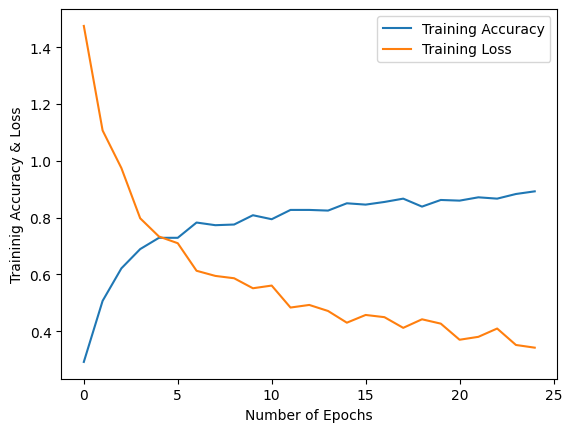

In [ ]:
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['loss'], label = 'Training Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Traininig Accuracy & Loss')
plt.legend()

Text(0, 0.5, 'Validation Loss')

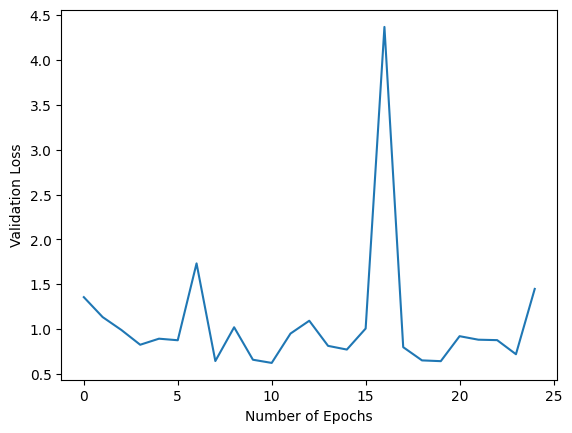

In [ ]:
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Loss')

Text(0, 0.5, 'Validation Accuracy')

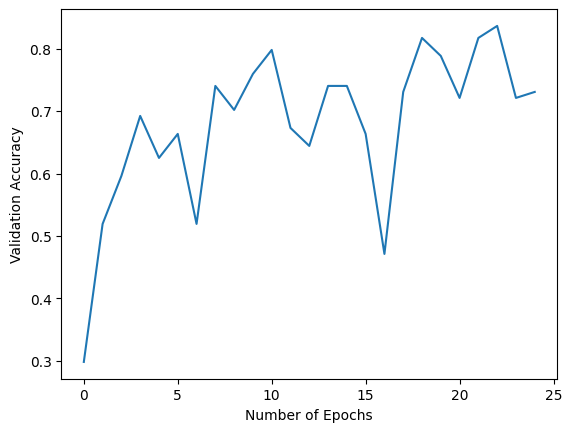

In [ ]:
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Accuracy')


# Test Model

In [ ]:
test_directory = '/content/drive/My Drive/Data Science Portfolio/Chest X-Ray Disease Classification Model/Test'

In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(256,256), class_mode = 'categorical')
evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4 , verbose = 1)

Found 40 images belonging to 4 classes.


<ipython-input-37-1a22d4de7dfb>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4 , verbose = 1)


 1/10 [==>...........................] - ETA: 2:33 - loss: 1.0130 - accuracy: 0.6500

10/10 [==============================] - 17s 10ms/step - loss: 1.0130 - accuracy: 0.6500


In [ ]:
print(f"Accuracy Test : {evaluate[1]}")

Accuracy Test : 0.6499999761581421


In [ ]:
# predicted labels
prediction = []
# true labels
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
        img= cv2.imread(os.path.join(test_directory,str(i),item))
        img = cv2.resize(img,(256,256))
        image.append(img)
        img = img / 255
        img = img.reshape(-1,256,256,3)
        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(i)

1/1 [==============================] - 0s 252ms/step


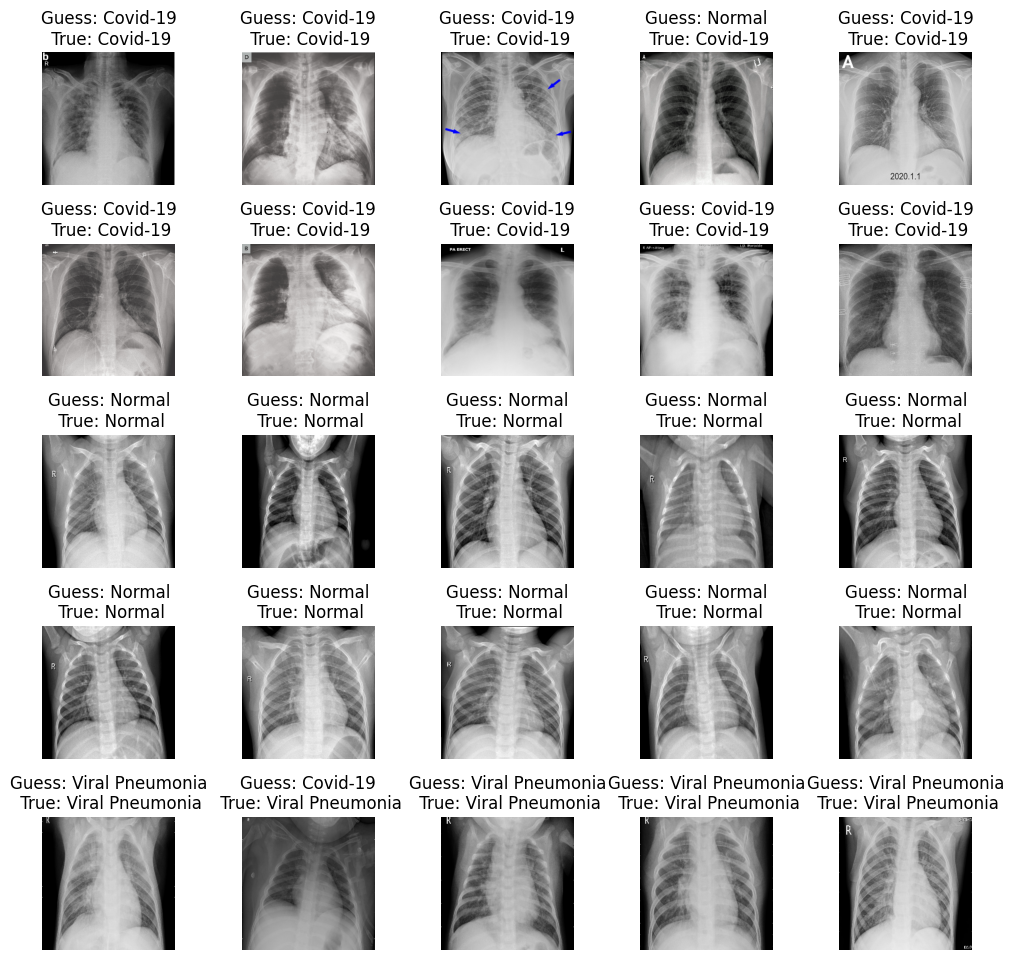

In [ ]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize=(12, 12))
axes = axes.ravel()

for i in range(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title(f"Guess= {str(label_names[prediction[i]])}\n True= {str(label_names[original[i]])}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)